In [4]:
# Useful starting lines
%matplotlib inline
import datetime
from costs import compute_loss
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload

%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [5]:
from proj1_helpers import *
DATA_TRAIN_PATH = "train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
# standardize the data
tX_std = standardize(tX)

# Implement ML methods

## least squares GD

In [6]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    # ***************************************************
    return (-1/len(y))*tx.T@(y-tx@w)
    # ***************************************************


def least_squares_GD(y, tx, initial_w, max_iter, gamma):
    """least square gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iter):
        gradient = compute_gradient(y,tx,w)
        loss = compute_loss(y,tx,w)
        w = w-gamma*gradient
        ws.append(w)
        losses.append(loss)

    return np.array(ws)[-1], np.array(losses)

## least square SGD

In [7]:

def compute_stoch_gradient(y, tx, w):
    """Compute the gradient."""
    # ***************************************************
    e = y-tx@w
    return -1/len(y)*tx.T@e
    # ***************************************************


def least_squares_SGD(y, tx, initial_w, batch_size, max_iters, gamma):
    """Least square stochastic gradient descent algorithm."""
    # ***************************************************
    # Define parameters to store w and loss
    ws = []
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute random batch
        a = batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
        a = list(a)
        tx2, y2 = a[0][1], a[0][0]
        
        # compute gradient & loss
        grad = compute_stoch_gradient(y2,tx2,w)
        loss= compute_loss(y2, tx2, w)
        print(grad)
        # update gradient
        w = w-gamma*grad
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        #print("stoch Gradient Descent({bi}/{ti}): loss={l}".format(
              #bi=n_iter, ti=max_iters - 1, l=loss))

    return np.array(losses), np.array(ws)

## least square
computed by solving for w:  X<sup>T</sup>X * w = X<sup>T</sup>y

In [8]:
def least_square(y, tx):
    w = np.linalg.solve(tx.T@tx,tx.T@y)
    return w, compute_loss(y, tx, w)


In [9]:
wls, loss = least_square(y_std, tX_std)

NameError: name 'y_std' is not defined

## Ridge regression

In [13]:
def ridge_regression(y, tx, lamda):
    w = np.linalg.solve(tx.T@tx+lamda*np.eye(tx.shape[1]),tx.T@y)
    return w, compute_loss(y, tx, w)


In [ ]:
wls, loss = ridge_regression(y, tX_std,0)
print(loss)

## Logistic regression

In [14]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def update_weights(tx, y, w, gamma):
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y)
    w -= gradient*gamma / len(tx)
    return w

def loss_function_LR(tx, y, w):
    #probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    #the error when label=1
    error1 = -y*np.log(probabilities)
    #the error when label=-1
    error2 = (1-y)*np.log(1-probabilities)
    #return average of sum of costs
    return (error1-error2).mean()


# logistic regression function
def logistic_regression(y,tx, initial_w,  max_iter, gamma):
    losses = []
    ws = []
    for iter_n in range(max_iter):
        w = update_weights(tx, y, initial_w, gamma)
        loss = loss_function_LR(tx, y, w)
        losses.append(loss)
        ws.append(w)
    return np.array(losses)[-1], np.array(ws)[-1]



## regularized logistic regression

In [15]:
def reg_LR_update_weights(y, tx, w, gamma, lambda_):
    """
    Update weights function for  regularized logistic regression
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param gamma: learning rate
    :param lambda_: regulizer
    
    :return w: new updated weights
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    gradient = np.dot(tx.T,  probabilities - y) + lambda_ * w
    w -= gradient*gamma / len(tx)
    return w

def reg_LR_loss_function(y, tx, w, lambda_):
    """
    Computes logistic loss
    
    :param tx: features matrix
    :param y: labels vector
    :param w: weights
    :param lambda_: regulizer
    
    :return w: logistic loss
    """ 
    # probabilities array that the label is 1
    probabilities = sigmoid(np.dot(tx, w))
    # the error when label=1
    error1 = -y*np.log(probabilities)
    # the error when label=0
    error2 = (1-y)*np.log(1-probabilities)
    # return average of sum of costs
    return (error1-error2).mean()+lambda_/2*np.dot(w.T,w)/ len(tx)


# regularized logistic regression function
def reg_logistic_regression(y,tx, initial_w,max_iter, gamma,lambda_):
    """
    Regularized logistic regression function
    
    :param tx: features matrix
    :param y: labels vector
    :param initial_w: initial weights
    :param max_iter: number of iterations
    :param gamma: learning rate
    :param lambda_: regulizer

    :return ls: last loss  computed
    :return ws: last weights computed
    """ 
    losses = []
    ws = []
    for iter_n in range(max_iter):
        w = reg_LR_update_weights(y, tx, initial_w, gamma,lambda_)
        loss = reg_LR_loss_function(y, tx, w, lambda_)
        losses.append(loss)
        ws.append(w)
    ls, wes  = np.array(losses), np.array(ws)
    return wes[-1],ls


# Useful functions

In [16]:
def compute_accuracy(y_pred, y):
    """
    compute the accuracy
    
    :param y_pred: predictions
    :param y: real labels
    
    :return acc: accuracy
    """
    # y_pred - y & count 0
    arr = np.array(y_pred) - np.array(y)
    acc = np.count_nonzero(arr==0) / len(y)
    return acc


def build_k_indices(y, k_fold, seed):
    """
    build k indices for k-fold.
    
    :param y: labels
    :param k_fold: number of folds
    :param seed: seed for randomization
    
    :return k_indices: indices 
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def build_poly(x, degree):
    """
    polynomial basis functions for input data x, for j=0 up to j=degree.
    
    :param x: matrix 
    :param degree: degree of expansion
    """
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly


def cross_validation(y, x, k_indices, k, degree, logistic, regression_method, **kwargs):
    """
    Computes cross validation on a given data set using a given regression method, and computes the
    weights, the train loss, the test loss, and the train and loss accuracy
    if the degree is not none, it will perform feature expansion on the data set
    
    :param y: labels vector
    :param tx: features matrix
    :param k_indices: k_fold already randomly computed indices
    :param degree: degree of polynomial expansion
    :param logistic: boolean; if true, the loss used is the logistic one
    :param **kwargs: differents parameters such as the regulizer lambda or the learning rate gamma
    """
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    train_indice = train_indice.reshape(-1)
    
    y_test = y[test_indice]
    y_train = y[train_indice]
    x_test = x[test_indice]
    x_train = x[train_indice]
    
    if degree != None:
        x_train = build_poly(x_train, degree)
        x_test = build_poly(x_test, degree)

    
    w_initial = np.zeros(x_train.shape[1])
    kwargs = kwargs
    kwargs['initial_w'] = w_initial

    w, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)
    if logistic == True:
        loss_test = reg_LR_loss_function(y_test, x_test, w ,kwargs['lambda_'])
    else:
        loss_test = compute_loss(y_test, x_test, w)
    y_train_pred = predict_labels(w, x_train)
    y_test_pred = predict_labels(w, x_test)
    y_test = (y_test*2)-1
    y_train = (y_train*2)-1
    accuracy_train = compute_accuracy(y_train_pred, y_train)
    accuracy_test = compute_accuracy(y_test_pred, y_test)
    return w, loss_train, loss_test, accuracy_train, accuracy_test




# main 

## load train data

In [17]:
DATA_TRAIN_PATH = "train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# standardize the data
tX_std = standardize(tX)
y_std = (y+1)/2

## Train function

In [47]:
def train(model,y,tx,k_fold,degree,seed=0, **kwargs):
    """
    regularized logistic regression function 
    
    :param Model: model that we'll use
    :param y: labels vector
    :param tx: features matrix
    :param k_fold: number of folds
    :param degree: degree of polynomial expansion
    :param seed: random seed for cross validation split
    :param **kwargs: multiple possible parameters
    
    :return wf: final weights 
    """    
    weights = []
    losses_train = []
    losses_test = []
    accuracies_train = []
    accuracies_test = []
    
    logistic = False
    if model is logistic_regression or model is reg_logistic_regression:
        logistic = True
    
    k_indices = build_k_indices(y, k_fold, seed)
    for k in range(k_fold):
        w, loss_train, loss_test, accuracy_train, accuracy_test = cross_validation(y, tx, k_indices, k, degree, logistic, model,max_iter=200, **kwargs)
        weights.append(w)
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        accuracies_train.append(accuracy_train)
        accuracies_test.append(accuracy_test)
    leg = ["train loss "+str(i) for i in range(k_fold)]
    plt.legend(leg)
    for ls in losses_train:
        plt.plot(ls)
    
    print("<-"+"-"*100+"->")
    for i in range(k_fold):
        print(f'loss_train: {losses_train[i][-1]}, loss_test: {losses_test[i]}, accuracy_train: {accuracies_train[i]}, accuracy_test: {accuracies_test[i]}')
        print("\n")
    print("<-"+"-"*100+"->")

    return w, np.amin(losses_train), np.amin(losses_test), np.max(accuracies_train), np.max(accuracies_test) 
    

Done about : 0.0
<------------------------------------------------------------------------------------------------------>
loss_train: 0.33843849809698817, loss_test: 0.33663047349495595, accuracy_train: 0.34303, accuracy_test: 0.34122


loss_train: 0.33800540313766353, loss_test: 0.33839221659057706, accuracy_train: 0.342585, accuracy_test: 0.343


loss_train: 0.3374116972953924, loss_test: 0.3408072924747678, accuracy_train: 0.341975, accuracy_test: 0.34544


loss_train: 0.3380005368143699, loss_test: 0.33841201181414376, accuracy_train: 0.34258, accuracy_test: 0.34302


loss_train: 0.3385747494951707, loss_test: 0.33607623024674105, accuracy_train: 0.34317, accuracy_test: 0.34066


<------------------------------------------------------------------------------------------------------>
<------------------------------------------------------------------------------------------------------>
loss_train: 0.33771342028674556, loss_test: 0.339579944059319, accuracy_train: 0.342285, accuracy

<------------------------------------------------------------------------------------------------------>
loss_train: 0.30454927848742014, loss_test: 0.3018434058789044, accuracy_train: 0.34325, accuracy_test: 0.34034


loss_train: 0.30418518896726754, loss_test: 0.3035370844165894, accuracy_train: 0.34278, accuracy_test: 0.34222


loss_train: 0.3042316765608827, loss_test: 0.3033208336362216, accuracy_train: 0.34284, accuracy_test: 0.34198


loss_train: 0.3032433063528273, loss_test: 0.3079184611521, accuracy_train: 0.341565, accuracy_test: 0.34708


loss_train: 0.30428203545179955, loss_test: 0.30308657401253286, accuracy_train: 0.342905, accuracy_test: 0.34172


<------------------------------------------------------------------------------------------------------>
<------------------------------------------------------------------------------------------------------>
loss_train: 0.3043866181257371, loss_test: 0.3026000748539379, accuracy_train: 0.34304, accuracy_test: 0.34118


loss

<------------------------------------------------------------------------------------------------------>
loss_train: 0.22720447417384057, loss_test: 0.22835988487341255, accuracy_train: 0.34208, accuracy_test: 0.34502


loss_train: 0.2274649081968446, loss_test: 0.2270017190460848, accuracy_train: 0.342875, accuracy_test: 0.34184


loss_train: 0.22757264843509067, loss_test: 0.2264408026134921, accuracy_train: 0.343205, accuracy_test: 0.34052


loss_train: 0.2273667769872509, loss_test: 0.2275130942467836, accuracy_train: 0.342575, accuracy_test: 0.34304


loss_train: 0.2273765980598587, loss_test: 0.22746189453366783, accuracy_train: 0.342605, accuracy_test: 0.34292


<------------------------------------------------------------------------------------------------------>
<------------------------------------------------------------------------------------------------------>
loss_train: 0.22735040460616487, loss_test: 0.22759845781459165, accuracy_train: 0.342525, accuracy_test: 0.3432

<------------------------------------------------------------------------------------------------------>
loss_train: 0.33792267537633286, loss_test: 0.3387287364711238, accuracy_train: 0.3425, accuracy_test: 0.34334


loss_train: 0.33780101587950456, loss_test: 0.3392236228171762, accuracy_train: 0.342375, accuracy_test: 0.34384


loss_train: 0.33852122234259036, loss_test: 0.3362939679232431, accuracy_train: 0.343115, accuracy_test: 0.34088


loss_train: 0.3377474853145993, loss_test: 0.33944137438166444, accuracy_train: 0.34232, accuracy_test: 0.34406


loss_train: 0.33843849809698817, loss_test: 0.336630473494956, accuracy_train: 0.34303, accuracy_test: 0.34122


<------------------------------------------------------------------------------------------------------>
<------------------------------------------------------------------------------------------------------>
loss_train: 0.3379470071293723, loss_test: 0.338629759797453, accuracy_train: 0.342525, accuracy_test: 0.34324


lo

<------------------------------------------------------------------------------------------------------>
loss_train: 0.30382870551245283, loss_test: 0.30519536196654473, accuracy_train: 0.34232, accuracy_test: 0.34406


loss_train: 0.30363878258928656, loss_test: 0.3060788312811255, accuracy_train: 0.342075, accuracy_test: 0.34504


loss_train: 0.3043323915671306, loss_test: 0.302852326926089, accuracy_train: 0.34297, accuracy_test: 0.34146


loss_train: 0.3041696925771744, loss_test: 0.30360917038396157, accuracy_train: 0.34276, accuracy_test: 0.3423


loss_train: 0.3045221704390288, loss_test: 0.3019695082870954, accuracy_train: 0.343215, accuracy_test: 0.34048


<------------------------------------------------------------------------------------------------------>
<------------------------------------------------------------------------------------------------------>
loss_train: 0.30394496539121824, loss_test: 0.30465455029527244, accuracy_train: 0.34247, accuracy_test: 0.34346


l

<------------------------------------------------------------------------------------------------------>
loss_train: 0.22747797900720806, loss_test: 0.22693364010888342, accuracy_train: 0.342915, accuracy_test: 0.34168


loss_train: 0.2273422165749626, loss_test: 0.22764115399503407, accuracy_train: 0.3425, accuracy_test: 0.34334


loss_train: 0.2272832265261298, loss_test: 0.22794884981809474, accuracy_train: 0.34232, accuracy_test: 0.34406


loss_train: 0.2275742792186205, loss_test: 0.2264323167405726, accuracy_train: 0.34321, accuracy_test: 0.3405


loss_train: 0.22730781344391257, loss_test: 0.2278205827596915, accuracy_train: 0.342395, accuracy_test: 0.34376


<------------------------------------------------------------------------------------------------------>


KeyboardInterrupt: 

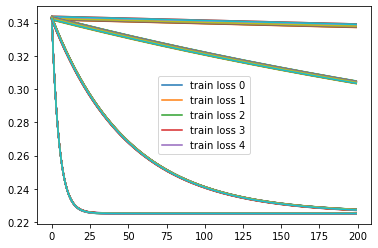

In [61]:
#wf = train(reg_logistic_regression,y_std,tX_std,5,0,5,gamma=0.1757, lambda_ = 0)
#w, lossTr, lossTe, accTr, accTe = train(names[0],y_std,tX_std,5,degrees[0],None,gamma = gammas[3], lambda_ = 0)

names = [least_squares_GD, least_squares_SGD,least_square, ridge_regression, logistic_regression,reg_logistic_regression]
initial_w  = np.zeros(tX_std.shape[1])
lambdas = np.logspace(-5, 0, 15)
gammas = np.array([0.0001,0.001,0.01,0.1])
degrees = np.array([0,1,2,3,4,5,6,7])
parameters = [{'gamma' : gammas[0],'lambda_' : lambdas[0]}]
#wf = train(reg_logistic_regression,y_std,tX_std,5,0,None,**(parameters[0]))
bestParametersLossTrain = [names[0], lambdas[0], gammas[0],degrees[0], 1, initial_w ]
bestParametersLossTest = [names[0], lambdas[0], gammas[0],degrees[0], 1, initial_w ]
bestParametersAccuracyTrain = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]
bestParametersAccuracyTest = [names[0], lambdas[0], gammas[0],degrees[0], 0, initial_w ]

for index, model_name in enumerate(names):
    print("Done about : " + str(index/len(names)))
    for lambda_ in lambdas:
        for gamma in gammas:
            for degree in degrees:
                parameters = [{'gamma' : gamma}, {'gamma' : gamma}, {}, {'lambda_' : lambda_}, {'gamma' : gamma}, {'gamma' : gamma,'lambda_' : lambda_}]
                wTemp, lossTr, lossTe, accTr, accTe = train(model_name,y_std,tX_std,5,0,None,**parameters[index])
                if lossTr < bestParametersLossTrain[4]:
                    bestParametersLossTrain = [model_name,lambda_, gamma, None, lossTr, wTemp]             
                if lossTe < bestParametersLossTest[4]:
                    bestParametersLossTrain = [model_name,lambda_, gamma, None, lossTe, wTemp]
                if accTr > bestParametersAccuracyTrain[4]:    
                    bestParametersLossTrain = [model_name,lambda_, gamma, None, accTr, wTemp]                    
                if accTe > bestParametersAccuracyTest[4]:
                    bestParametersLossTrain = [model_name,lambda_, gamma, None, accTe, wTemp]                    
                           
                

#The parameters are : Lambda, degrees, gamma
#


## Generate predictions and save ouput in csv format for submission:

In [ ]:
# load test data
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

# standardize wrt the tx train mean and std
def standardize_test(tx, tx_test):
    centered_data = tx_test - np.mean(tx, axis=0)
    std_data = centered_data / np.std(tx, axis=0)
    return std_data
tX_test_std = standardize_test(tX, tX_test)
OUTPUT_PATH = 'outLogRegD23v2.csv' 
y_pred = predict_labels(wk, tX_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)


In [46]:
xsdfqfdsf = np.array([1,2,3])
np.max(xsdfqfdsf)

3